# News Clustering using KMeans Algorithm

In [1]:
import numpy as np
import pandas as pd
from time import time
import articles_data_py3 as articles_data
from pymongo import MongoClient
import datetime

## Load data from MongoDB 

In [2]:
client = MongoClient('mongodb://localhost:27017/somanews')
client.somanews.authenticate('ssomanews', 'ssomanews1029')
db = client.get_database('somanews')

crawled_collection = db.get_collection('crawledArticles')
clusters_collection = db.get_collection('aclusters')
articles_collection = db.get_collection('aarticles')

## Select Categories
- 포함 : 경제, 문화, 건강, 과학, 사회, 정치, 스포츠
- 제외 : 종합, 정보없음, 인물, 사설

In [3]:
catelist_path = '../datastore/category.p'
headline_path = '../datastore/headline.p'
target_time = datetime.datetime.now()

In [4]:
train = articles_data.find_recent_articles(crawled_collection, catelist_path, target_time)

## Preprocessing
1. Datetime (16-09-11 ~ 16-09-17)
2. Remove stopwords (regex, hanja)
3. POS Tagging with KoNLPy, Mecab
4. Using bigram

In [5]:
from konlpy.tag import Mecab
import cnouns
import hanja
import re

In [6]:
mecab = Mecab()

In [7]:
def tokenize(data):
    return [' '.join(e for e in mecab.nouns(data))]

In [8]:
train['title_flat'] = train['title'].apply(lambda text: articles_data.remove_headlines(text, headline_path))
train['title_flat'] = train['title_flat'].apply(lambda text: cnouns.text_cleaning_without_special_ch(text))
title = [tokenize(each[1]['title_flat']) for each in train.iterrows()]

## Training
1. Feature extraction - TfidVectorizer
2. Decomposition - PCA
3. Cluster - KMeans

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [10]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
title_flat = [item for sublist in title for item in sublist]
x_list = vectorizer.fit_transform(title_flat)

In [11]:
x_list_100d = PCA(n_components=100).fit_transform(x_list.toarray())
x_list_100d.shape

(2413, 100)

### Scoring

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Best Silhoutte Score

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
best_score = 0.0
best_k = 0

In [15]:
k_list = []
score_list = []
for k in range(20, 35):
    km = KMeans(n_clusters=k, n_jobs=-1).fit(x_list_100d)
    score = silhouette_score(x_list_100d, km.labels_)
    if best_score < score:
        best_score = score
        best_k = k
    k_list.append(k)
    score_list.append(score)
print("In Clusters =", best_k, ", Best score is : %0.3f" % best_score)

In Clusters = 25 , Best score is : 0.195


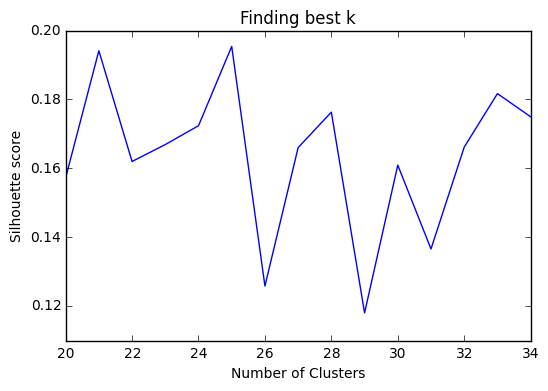

In [16]:
x = k_list
y = score_list
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.title('Finding best k')
plt.plot(x, y)
plt.show()

### K-Means Algorithm

In [17]:
km = KMeans(n_clusters=best_k, n_jobs=-1).fit(x_list_100d)
labels = km.labels_
centroids = km.cluster_centers_
print(km.inertia_)

249.135532738


In [18]:
x_list_vector = x_list_100d.tolist()
train = train.drop(['title_flat'], axis=1)
train['vector'] = x_list_vector
train['cluster'] = labels

## Choose Best Cluster
- Minimum inertia

In [19]:
sample_silhouette_values = silhouette_samples(x_list_100d, labels)
sample_silhouette_score = []
list_silhouette_score = []
best_cluster = []

for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]    
    list_silhouette_score.append(abs(ith_cluster_silhouette_values.mean()))

list_silhouette_score.sort(reverse=True)
sample_silhouette_score = list_silhouette_score[:12]

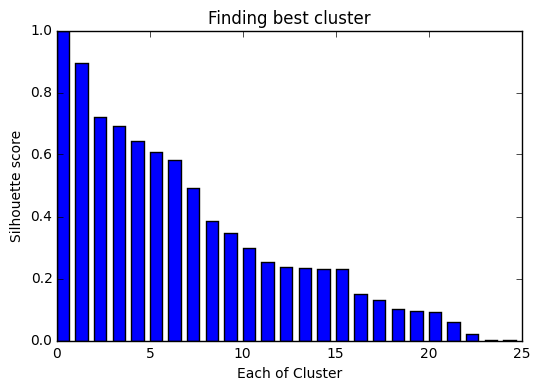

In [20]:
x = [x for x in range(best_k)]
y = list_silhouette_score
width = 1/1.5
plt.xlabel('Each of Cluster')
plt.ylabel('Silhouette score')
plt.title('Finding best cluster')
plt.bar(x, y, width)
plt.show()

In [21]:
sample_silhouette_score

[1.0,
 0.89569433339431492,
 0.71974811131808314,
 0.69034386214393828,
 0.64362188435602696,
 0.60889428640946663,
 0.58312090994246768,
 0.49304287999023461,
 0.38497870778062321,
 0.34649285352501391,
 0.29818995067954873,
 0.25468810986809504]

In [22]:
cohesions = []

In [23]:
for i in range(best_k):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labels == i]
        
    if abs(ith_cluster_silhouette_values.mean()) in sample_silhouette_score:
        best_cluster.append(i)
        cohesions.append(abs(ith_cluster_silhouette_values.mean()))

In [24]:
train = train[train['cluster'].isin(best_cluster)]
cohesions

[0.49304287999023461,
 0.69034386214393828,
 1.0,
 0.89569433339431492,
 0.60889428640946663,
 0.58312090994246768,
 0.71974811131808314,
 0.38497870778062321,
 0.64362188435602696,
 0.25468810986809504,
 0.34649285352501391,
 0.29818995067954873]

## Save to MongoDB

In [25]:
articles_collection.insert_many(train.to_dict(orient='records'))
articles_data.save_to_db(train, 1108, clusters_collection, cohesions)
client.close()

## Result

In [26]:
cluster_data = []

for cluster_index in range(best_k):
    if cluster_index in best_cluster:
        cluster_data.append(train[train['cluster'] == cluster_index])
    
for i, d in enumerate(cluster_data):
    print('Cluster %d:' % (i), 'Size %d' % (len(d)))

    display(d[['title', 'category']].sample(min(len(train.cluster.unique()), len(d))))
    print('\n\n')

Cluster 0: Size 12


,title,category
1768,‘1000억 비자금’ 엘시티 이영복 체포,뉴스 > 정치 > 정치일반
1713,‘비자금 의혹’ 엘시티 이영복 회장 체포,사회 > 법원·검찰
1678,해운대 ‘엘시티’ 이영복 회장 체포,사회 > 법원·검찰
2091,'엘시티 이영복 리스트' 있나… 與 중진의원 등 3~4명 거론,사회 > 법원ㆍ검찰ㆍ경찰
315,‘엘시티 비자금’ 이영복 도피 도운 강남 유흥업소 직원 구속,사회 > 법원·검찰
1897,"검찰, ‘엘시티’ 수사 본격화…이영복 회장 검거",사회 > 전국
1696,‘수백억 횡령’ 부산 엘시티 이영복 회장 검거,사회 > 사회일반
1814,엘시티 이영복 “성실히 조사받겠다”···부산구치소 수감,사회 > 법원·검찰
2047,"[단독]엘시티 이영복, 2000억 빚더미서 2조7000억 사업 따내",뉴스 > 정치 > 동아일보 단독
2012,"검찰, ‘엘시티’ 이영복 회장 영장 청구…횡령·사기 혐의",사회 > 사회일반





Cluster 1: Size 6


,title,category
1316,[간추린 뉴스]두산밥캣 공모주 청약 미달 外,뉴스 > 경제 > 경제일반
748,"두산밥캣 청약 첫날, 경쟁률 0.3대1 ‘불안한 출발’",마켓·비즈 > 금융·재테크
297,"두산밥캣 공모가 3만원 확정, 상장 재도전",경제 > 경제일반
1185,트럼프 당선 때문에? 두산밥캣 공모주 청약 미달,마켓·비즈 > 경제일반
401,"두산밥캣, 공모가 낮춰 상장 재도전",경제 > 경제일반
180,두산밥캣 공모가 3만원 확정···8일부터 일반 청약,마켓·비즈 > 금융·재테크





Cluster 2: Size 1


,title,category
432,[박근혜·최순실 게이트]‘최순실 게이트’ 우병우 의혹 뒷북 수사,정치 > 정치일반





Cluster 3: Size 3


,title,category
738,경기 광주~강원 원주 제2영동고속도로 11일 개통,사회 > 전국
788,광주~원주 ‘제2영동고속도로’ 11일 개통,전국 > 전국일반
736,광주~원주 제2영동고속도로 11일 개통,사회 > 전국





Cluster 4: Size 5


,title,category
2374,충남 보령서 규모 3.5 지진 발생,사회 > 사회일반
2366,[속보]뉴질랜드 크라이스트처치 인근서 규모 7.4지진 발생,국제 > 국제일반
2380,충남 보령서 규모 3.5 지진 발생,사회 > 사건·사고
2378,[속보]기상청 “충남 보령서 규모 3.5 지진”,사회 > 사건·사고
1697,경북 영덕군 해역서 규모 2.5 지진,사회 > 사건·사고





Cluster 5: Size 15


,title,category
2355,"이 시국에…정부, 한·일군사협정 오늘 가서명 강행",정치 > 국방·북한
1856,‘한·일 정보협정’ 법제처에 심사 의뢰 국방부 “다음주 협정 가서명”,정치 > 국방·북한
814,한·일 군사정보협정 ‘속전속결’ 체결 강행,정치 > 국방·외교
2074,韓·日 군사정보보호협정 내주 가서명,정치 > 외교
1205,"국방부 “한일 군사정보협정, 주요 내용 의견 일치”",정치 > 국방·북한
1687,“한·일 군사협정 강행 땐 국방장관 해임건의”,정치 > 국회·정당
614,"이 와중에…국방부, ‘한일 군사협정’ 2차 협상도 강행",정치 > 국방·북한
1839,"국방부, 반대여론 무시하고 “한일 군사정보협정, 법제처 심사의뢰 요청”",정치 > 국방·외교
629,"정부, '최순실 게이트' 틈타 한일군사정보보호협청 체결 서둘러",정치 > 국방·외교
2263,"국방부, 한일군사정보협정 내일 가서명 ‘반대여론 묵살’",정치 > 국방·외교





Cluster 6: Size 10


,title,category
689,"한진해운 이후, 韓 해운업은 어디로",마켓·비즈 > 경제일반
779,“제2의 한진해운 막으려면 해운·조선 자금 흐름 이어야”,마켓·비즈 > 경제일반
1674,"한진해운, 선원 640명 일괄 해고",마켓·비즈 > 경제일반
687,한진해운 9월 말 이후 운송대금 583억여원 받아,경제 > 경제일반
1666,한진해운 대량실직 현실로해상직원 580명 해고 통보,경제 > 경제일반
880,한진해운 화물 95.5% 하역… 물류대란 두달만에 마무리,뉴스 > 경제 > 경제일반
607,한진해운 물류대란 마무리 단계…“97척 중 3척 하역만 남아”,경제 > 경제일반
1498,"한진해운, 선원 600여명 일괄 해고 통보",경제 > 경제일반
1745,"한진해운, 해상직원 560명 일괄 해고",뉴스 > 경제 > 경제일반
1480,"한진해운, 해상직원 600여명에 해고통보··· 대량실직 현실화",마켓·비즈 > 경제일반





Cluster 7: Size 15


,title,category
265,"민병희 강원도교육감 “박 대통령 자격 잃었다, 국정교과서 철회하라”",전국 > 강원
1251,“역사 국정교과서 반대” 학생·시민단체 ‘1인 시위’ 돌입,사회 > 교육·입시
1455,"이청연 교육감 “청소년들, 민주주의 반하는 국정교과서 안 믿어”",사회 > 전국
1594,"[단독]국정교과서 의견수렴한다더니…비공개 접수형, 토론 댓글 차단",사회 > 교육·입시
531,8일 미국은 새 역사를 쓴다,뉴스 > 국제 > 미국/북미
2262,한국교총 “교육현장 여론과 배치시 국정 교과서 반대”,사회 > 교육
1515,이청연 인천교육감 “민주주의 역행 역사 교과서 국정화 중단” 촉구,전국 > 서울·수도권 서울 경기 인천
1681,[단독]역사교과서 의견수렴 ‘깜깜이’ 진행…반대여론 차단 ‘꼼수’,사회 > 교육·입시
1114,“박근혜 퇴진과 역사교과서 국정화 중단하라”,사회 > 전국
362,역사교사들 ”국정교과서 당장 중단해야…학교 현장 혼란 없어”,사회 > 교육





Cluster 8: Size 5


,title,category
447,‘차은택 측근’ 송성각 전 콘텐츠진흥원장 체포,사회 > 사회일반
1695,[속보] ‘차은택 은사’ 송성각 전 콘텐츠진흥원장 영장 발부,사회 > 사회일반
440,[속보]'최순실 게이트' 송성각 전 콘텐츠진흥원장 체포,사회 > 법원·검찰
1703,[속보]‘최순실 게이트’ 송성각 전 콘텐츠진흥원장 구속,사회 > 법원·검찰
446,"‘최순실 의혹’ 수사 검찰, 뇌물·강요혐의로 송성각 전 콘텐츠진흥원장 체포",사회 > 사회일반





Cluster 9: Size 21


,title,category
1456,‘트럼프 시대’ 정부부처 수장들의 생각은?,경제 > 경제일반
106,"“디지털시대 달라진 新명품족, 이렇게 잡아라”",뉴스 > 사회 > 사회일반
1418,포퓰리즘에 빠진 시대… 전 세계 '마초 리더' 열풍,국제
1706,[혼돈의 트럼프 시대]② ‘정치적 올바름’ 강요당한 유권자 분노 폭발,국제 > 미국·중남미
26,탈북민 3만명 시대,사회
2353,"‘1인 가구’ 시대, ‘맞춤형 주택’이 는다··· 방의 갯수· 거실 크기까지 선택",마켓·비즈 > 금융·재테크
54,[DBR]평판 나쁜 기업들 도태… 디지털시대 非시장요소 중요성 커져,뉴스 > 경제 > 경제일반
1994,[트럼프 시대의 한반도](하) 불확실해서 불안…북한에 대해선 ‘백지’,정치 > 국방·외교
1530,[미국 '트럼프 시대']아베노믹스 타격에 고심 중인 일본,국제 > 일본
2309,[미국 ‘트럼프 시대’]뉴욕타임스 “이제 남은 희망은 메르켈뿐”,국제 > 국제일반





Cluster 10: Size 16


,title,category
1230,‘굿판·전생 체험’ 박승주 안전처 장관 내정자 자진 사퇴,정치 > 정치일반
1240,"‘전생 체험’ 박승주, 국민안전처 장관 후보자 자진사퇴",정치 > 정치일반
480,[횡설수설/송평인]안전처 장관 후보자의 굿판,뉴스 > 정치 > 정치일반
293,"'굿판 참여' 박승주 안전처 장관 내정자 ""환태평양 지진대가 활동해서"" 해명",사회 > 사회일반
394,광화문 한복판 굿판 참석하고 전봉준 만났다는 장관 내정자,정치 > 정치일반
231,"‘전생 안전처’ 장관? 박승주 후보자, 전생 체험 고백 책도 썼다",사회 > 사회일반
13,"김병준 ""자진사퇴 없다… 이렇게 어려울지 몰랐을 것 같나""",정치
1227,"[속보] 박승주 안전처 장관 내정자, 자진 사퇴",정치 > 정치일반
1231,박승주 국민안전처 장관 내정자 일주일만에 자진사퇴,전국 > 전국일반
1350,‘굿판 논란‘ 박승주 안전처장관 후보자 자진 사퇴,뉴스 > 정치 > 국회





Cluster 11: Size 13


,title,category
1459,청와대 “국회가 조속히 총리후보자 추천해주길”,정치 > 청와대
521,“국회추천 총리에 내치 전권만 주면 돼”… 민주당 숨고르기,뉴스 > 정치 > 정치일반
618,"박 대통령 총리 지명 사실상 철회...""여야 합의로 좋은 분 추천하면 총리 임명""",정치 > 국회·정당
948,朴대통령 “국회 추천 총리가 내각 통할” 野 “권한 모호… 2선후퇴 먼저” 또 거부,뉴스 > 정치 > 정치일반
535,"""김병준 철회하고, 國會가 총리 추천하자""",정치
1212,야3당 ‘국회 추천 총리’ 공식 거부,정치 > 국회·정당
959,韓·日 군사협정 서두르는 정부… 野 추천 총리가 받아들일까,정치 > 외교
628,"박대통령 “국회 추천 총리, 내각 통할하도록 하겠다”",정치 > 청와대
529,"“朴대통령, 국회에 총리 추천 맡겨야… 빨리 양보하는게 최선”",뉴스 > 정치 > 정치일반
1270,야 3당 “박 대통령 결단 먼저”…‘총리 추천 제안’ 공식 거부,정치 > 국회·정당
